### To dos
- check skew of variables
    - apply transformations as required
- convert categoricals to dummy variables
- deal with nulls/nans (or don't)
- split off dependent/independent variables
- scale/normalise
- split into train/validate


Let's start off with some imports

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from collections import defaultdict
from src.analyse import test_trans
from src.analyse import analyse
from src.load import load
from src.load import clean

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200
plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100

We'll then load up the training data

In [3]:
train_data = pd.read_csv('data/train.csv')

In [4]:
drops = ['PoolQC', 'MiscFeature', 'FireplaceQu', 'Id']
fills = {'MasVnrArea': 0.0, 'LotFrontage': 0.0}

elec_na = train_data["Electrical"].isna()
clean_data = train_data.drop(elec_na.loc[elec_na == True].index)

clean_data = clean(clean_data, drop_list=drops, fill_na=fills)

# train_data = clean(trainmultiple_data, drop_list=drops, fill_na=fills)

In [5]:
skew_kurt = analyse(clean_data)

In [6]:
skew_kurt.loc[(skew_kurt.Skewness >= 1) | (skew_kurt.Kurtosis >= 1)]

,Skewness,Kurtosis
MiscVal,24.468441,700.524315
PoolArea,14.823236,223.112709
LotArea,12.203431,203.101592
3SsnPorch,10.300725,123.574970
LowQualFinSF,9.008149,83.174678
KitchenAbvGr,4.486640,21.514545
BsmtFinSF2,4.253594,20.096813
ScreenPorch,4.120572,18.423508
BsmtHalfBath,4.101759,16.382219
EnclosedPorch,3.088518,10.420906


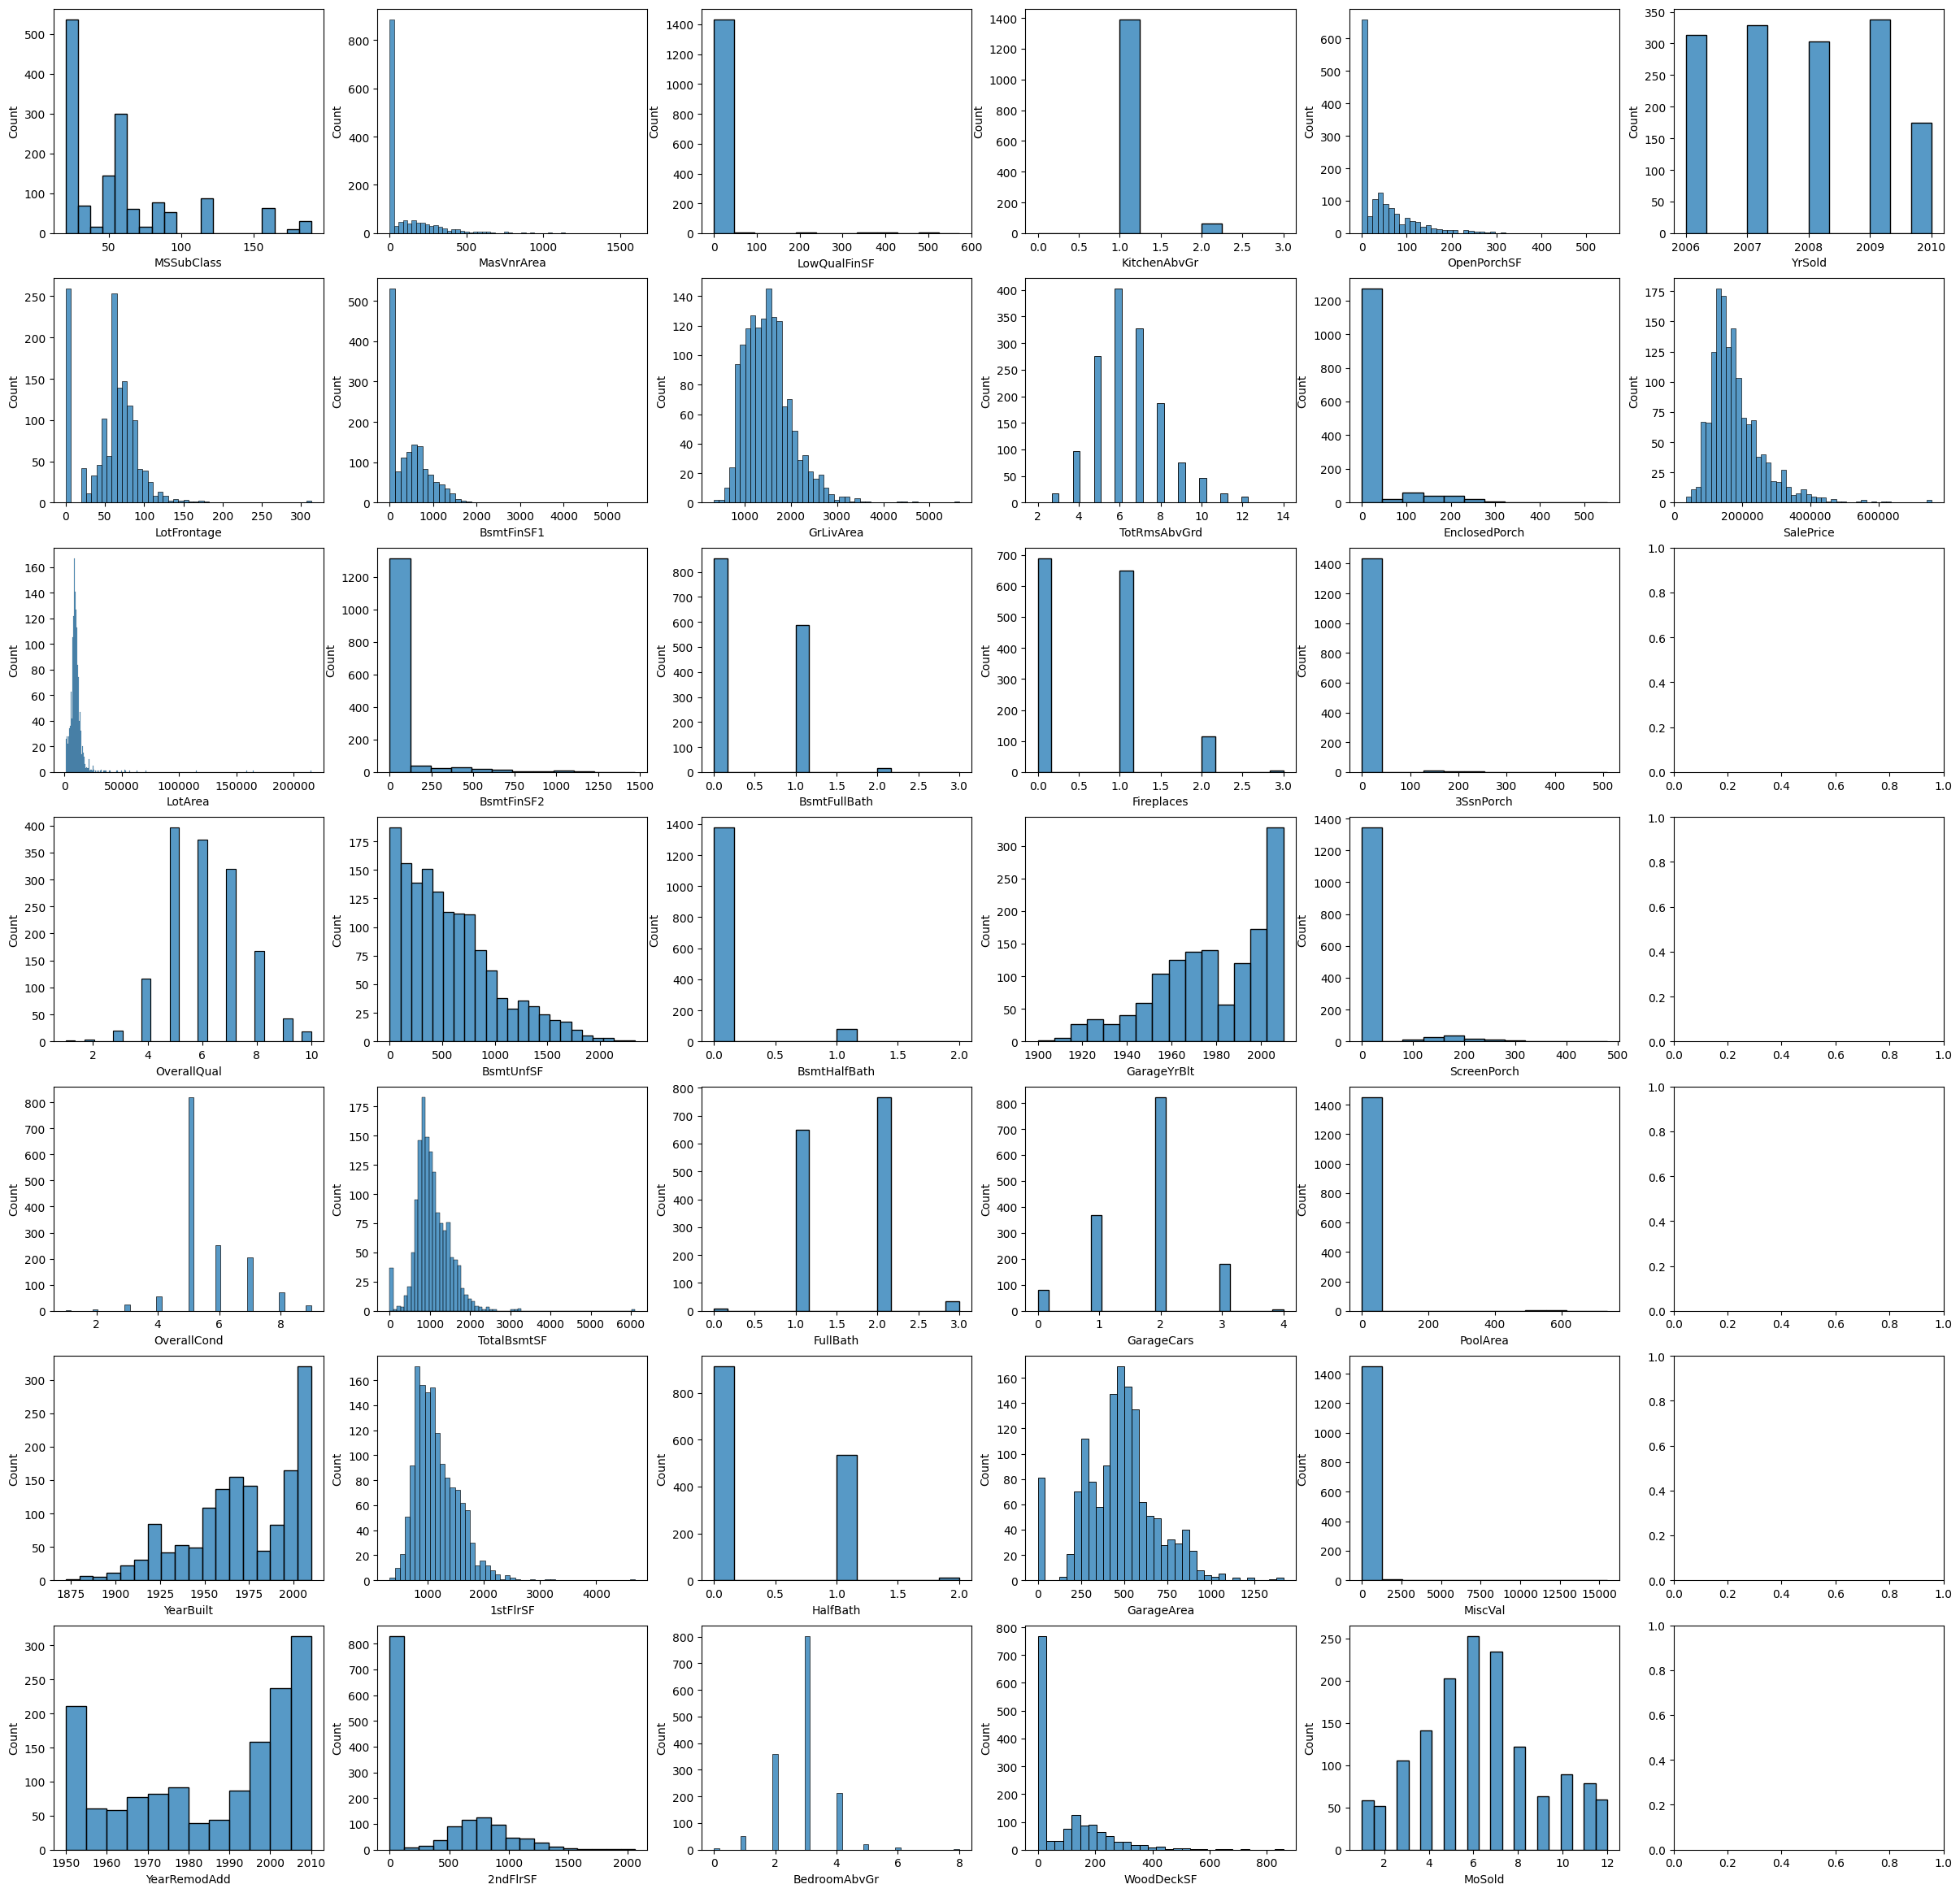

In [38]:
numerics = [col for col in clean_data.columns if clean_data.dtypes[col] != 'object']
categories = [col for col in clean_data.columns if clean_data.dtypes[col] == 'object']

fig, axs = plt.subplots(7,6, figsize=(30,30))
for i, column in enumerate(numerics):
    sns.histplot(data=clean_data, x = column, ax=axs[i%7, i//7])

# unique_count = defaultdict(list)
# for col in clean_data[numerics]:
#     unique_count[len(clean_data[col].unique())].append(col)

# for key in sorted(unique_count):
#     print('Number of unique values: {} | Column(s):\n{}'.format(key, unique_count[key]))

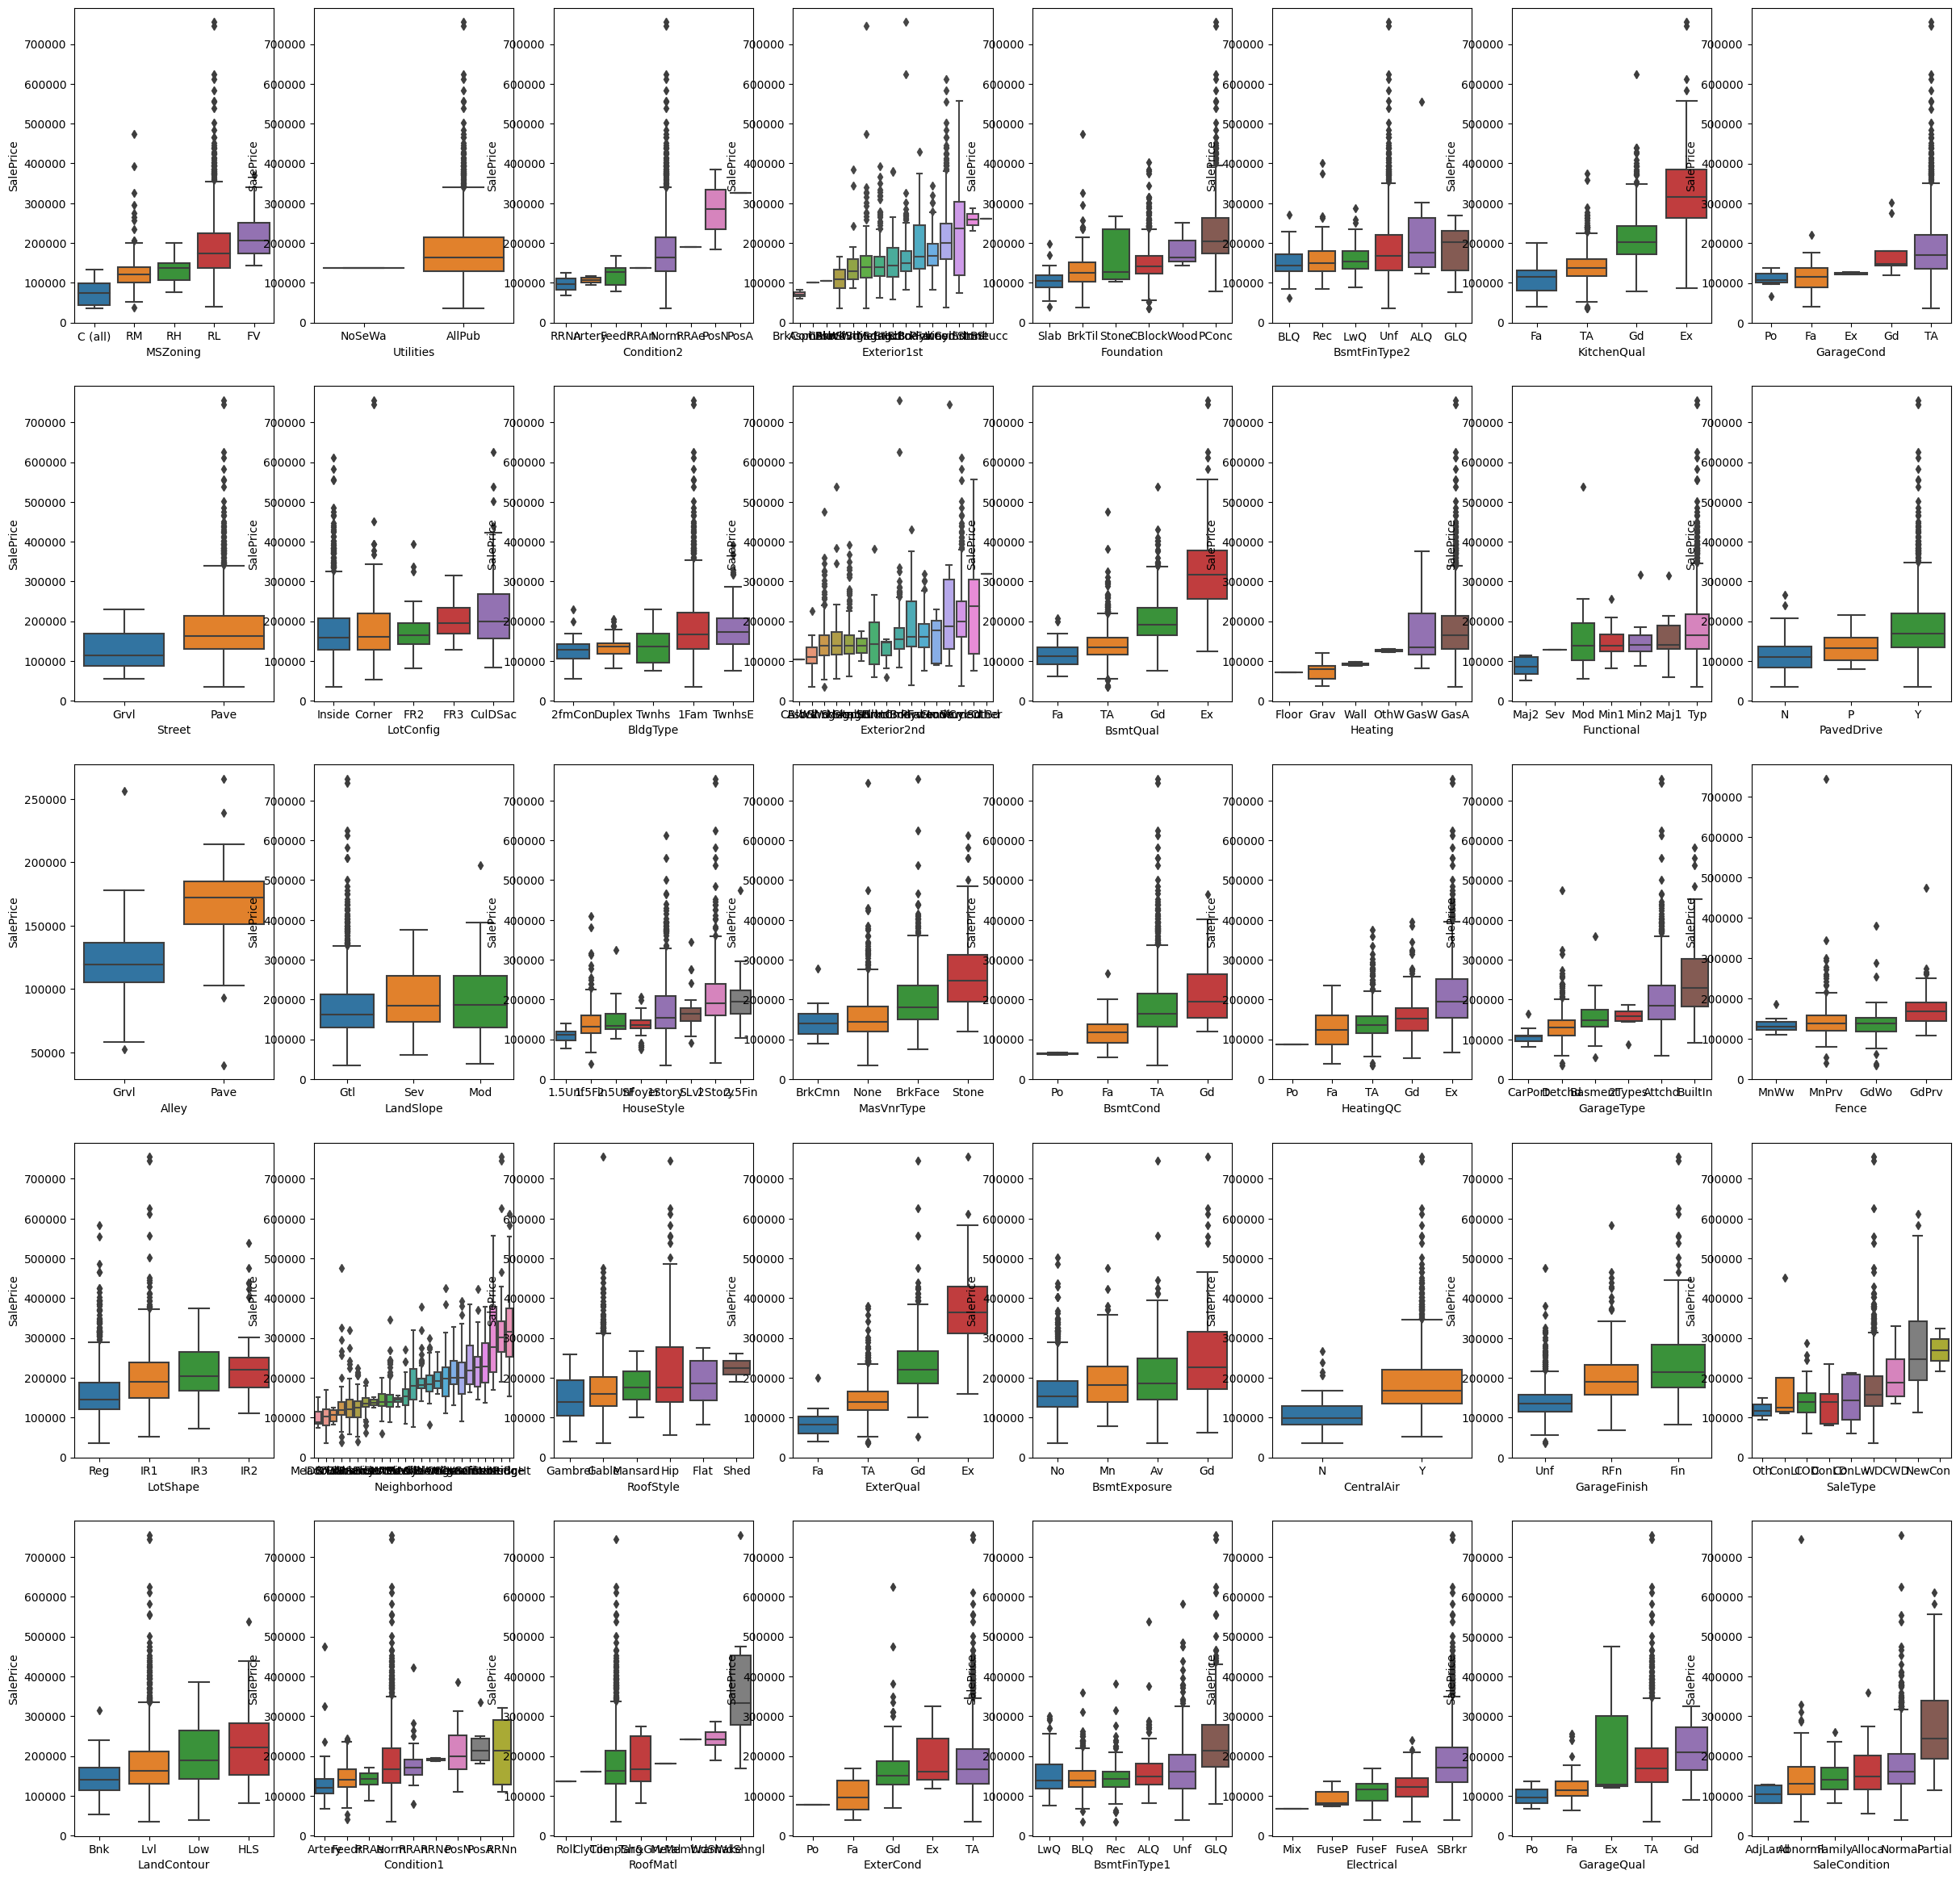

In [60]:
fig, axs = plt.subplots(5,8, figsize=(30,30))
# for i, column in enumerate(categories):
#     sort = sorted(clean_data.groupby(column)['SalePrice'].median().items(), )
#     sns.boxplot(data=clean_data, x = column, y=clean_data.SalePrice, ax=axs[i%5, i//5])
for i, column in enumerate(categories):
    # The box plots will be far more interpretable if we sort them by the median SalePrice. 
    # We can achieve this using a sorted function computed on this median
    sale_sort = sorted(clean_data.groupby(column)['SalePrice'].median().items(), key = lambda x:x[1])
    order = [value[0] for value in sale_sort]
    sns.boxplot(data=clean_data, x = column, y=clean_data.SalePrice, order = order, ax=axs[i%5, i//5])